In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Define the path to your zip file
zip_path = '/content/drive/My Drive/Datasets/monet.zip'

# Define the extraction path
extract_to = '/content/monet'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

os.makedirs('results', exist_ok=True)

# Unzip the file
!unzip -q "$zip_path" -d "$extract_to"

Mounted at /content/drive


In [42]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import shutil
import itertools
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [43]:
BATCH_SIZE = 5
MONET_IMAGES_PATH = "monet/monet_jpg"
TEST_IMAGES_PATH = "monet/photo_jpg"

lr = 0.0001
beta1 = 0.5
beta2 = 0.996
n_epochs = 50
decay_epoch = 51
display_epoch = 1

<div class="alert alert-warning" role="alert">
<a id="transform"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Dataset Transform
</h1></a>
</div>

In [44]:
transforms_dataset = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [45]:
class ImageDataset(Dataset):
    def __init__(self, directory_x, directory_y, test=False, transforms=None):
        self.transforms = transforms

        if test:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[250:]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[250:301]]
        else:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[:250]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[:250]]

    def __len__(self):
        return len(self.monet_images_X)

    def __getitem__(self, index):
        x_img =  Image.open(self.monet_images_X[index])
        y_img =  Image.open(self.test_images_Y[index])

        if self.transforms is not None:
            x_img = self.transforms(x_img)
            y_img = self.transforms(y_img)
        return x_img, y_img

In [46]:
train_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=False, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 3
)

test_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=True, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 3
)

<div class="alert alert-warning" role="alert">
<a id="discri"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 CycleGAN Discriminator
</h1></a>
</div>

In [47]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.scale_factor = 16

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        return self.model(x)


<div class="alert alert-warning" role="alert">
<a id="gener"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 CycleGAN Generator
</h1></a>
</div>

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        self.initial = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels, 64, 2 * in_channels + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.downsample_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(64, in_channels, 2 * in_channels + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)


<div class="alert alert-warning" role="alert">
<a id="training"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Training Loop
</h1></a>
</div>

In [49]:
G_XY = GeneratorResNet(3, num_residual_blocks=9)
D_Y = Discriminator(3)

G_YX = GeneratorResNet(3, num_residual_blocks=9)
D_X = Discriminator(3)

In [50]:
# Check for CUDA availability and define the Tensor type accordingly
cuda_available = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda_available else torch.Tensor
print(f'CUDA Available: {cuda_available}')

# Transfer models to CUDA if available
models = [G_XY, D_Y, G_YX, D_X]
for model in models:
    if cuda_available:
        model.cuda()

gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

CUDA Available: True


In [51]:
optimizer_G = torch.optim.Adam(itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))


In [52]:
def learning_rate_decay(epoch, decay_start_epoch, total_epochs):
    if epoch < decay_start_epoch:
        return 1
    else:
        return 1 - (epoch - decay_start_epoch) / (total_epochs - decay_start_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epochs))
lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epochs))
lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epochs))

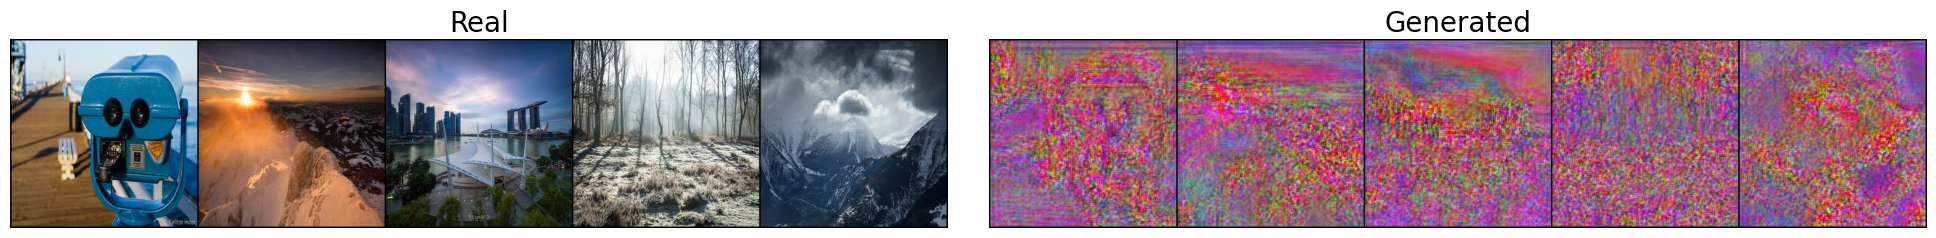

In [53]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def sample_images(real_X, real_Y):
    G_XY.eval()
    G_YX.eval()

    real_Y = real_Y.type(Tensor)
    fake_X = G_YX(real_Y).detach()

    ncols = real_Y.size(0)
    real_Y_grid = make_grid(real_Y, nrow=ncols, normalize=True)
    fake_X_grid = make_grid(fake_X, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(1, 2, figsize=(20, 15))

    axs[0].imshow(real_Y_grid.permute(1, 2, 0).cpu())
    axs[0].set_title("Real", fontsize=20)
    axs[0].axis('off')

    axs[1].imshow(fake_X_grid.permute(1, 2, 0).cpu())
    axs[1].set_title("Generated", fontsize=20)
    axs[1].axis('off')

    # Adjust layout to include more padding between subplots
    plt.tight_layout(pad=3.0)
    plt.show()

real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)


Epoch 1/50


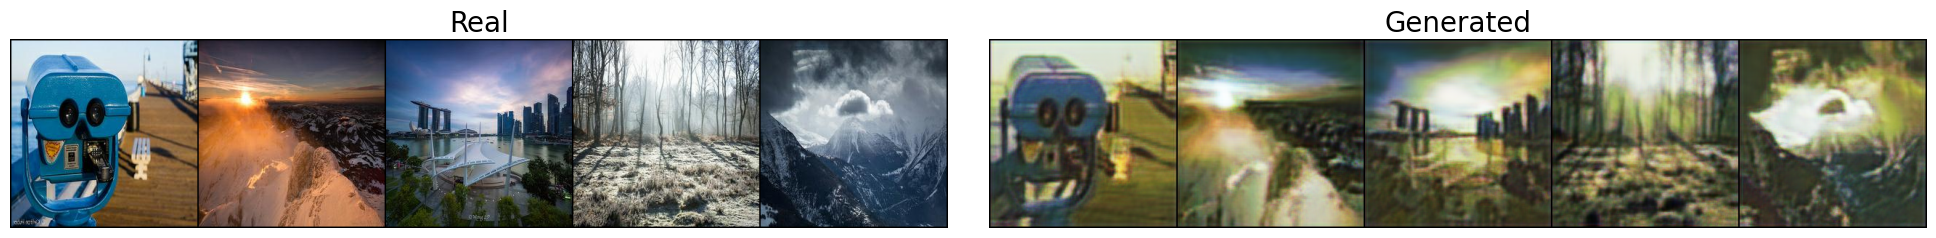

[Epoch 1 / 50]
[Generator loss: 4.260519981384277 | identity: 0.2669224739074707 GAN: 0.3408801555633545 cycle: 0.2585027813911438]
[Discriminator loss: 0.22195185720920563 | D_X: 0.2268601655960083 D_Y: 0.21704354882240295]
Epoch 2/50


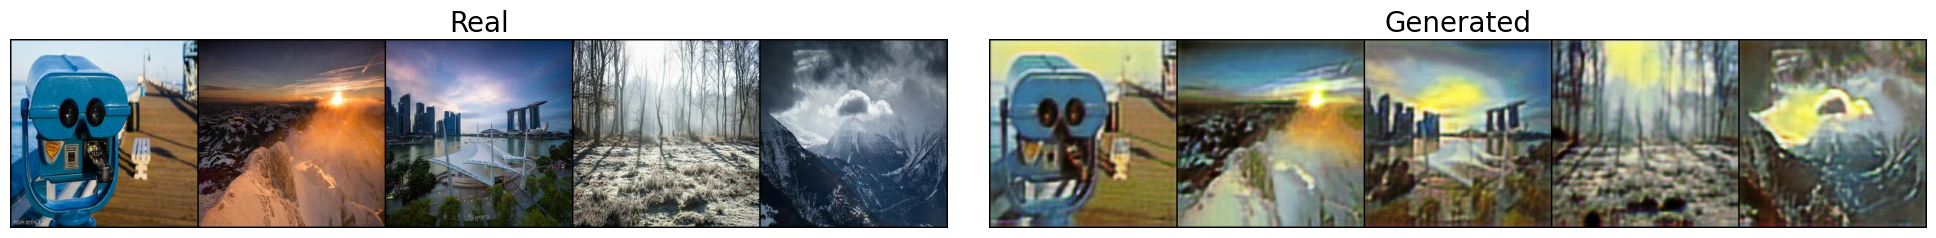

[Epoch 2 / 50]
[Generator loss: 3.617971420288086 | identity: 0.21610981225967407 GAN: 0.5414943695068359 cycle: 0.19959279894828796]
[Discriminator loss: 0.15988804399967194 | D_X: 0.19646137952804565 D_Y: 0.12331470847129822]
Epoch 3/50


In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Initialize lists to store losses
losses_G = []
losses_identity = []
losses_GAN = []
losses_cycle = []
losses_D_X = []
losses_D_Y = []
losses_D = []

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    for i, (real_X, real_Y) in enumerate(train_loader):
        real_X, real_Y = real_X.type(Tensor), real_Y.type(Tensor)
        out_shape = [real_X.size(0), 1, real_X.size(2) // D_X.scale_factor, real_X.size(3) // D_X.scale_factor]

        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)

        # Training generators
        G_XY.train()
        G_YX.train()

        optimizer_G.zero_grad()

        fake_Y = G_XY(real_X)
        fake_X = G_YX(real_Y)

        # Identity loss
        loss_id_X = identity_loss(fake_Y, real_X)
        loss_id_Y = identity_loss(fake_X, real_Y)
        loss_identity = (loss_id_X + loss_id_Y) / 2

        # GAN loss
        loss_GAN_XY = gan_loss(D_Y(fake_Y), valid)
        loss_GAN_YX = gan_loss(D_X(fake_X), valid)
        loss_GAN = (loss_GAN_XY + loss_GAN_YX) / 2

        # Cycle loss
        recov_X = G_YX(fake_Y)
        recov_Y = G_XY(fake_X)

        loss_cycle_X = cycle_loss(recov_X, real_X)
        loss_cycle_Y = cycle_loss(recov_Y, real_Y)
        loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

        # Total GAN loss
        loss_G = 5.0 * loss_identity + loss_GAN + 10.0 * loss_cycle

        loss_G.backward()
        optimizer_G.step()

        # Training discriminator X
        optimizer_D_X.zero_grad()

        loss_real = gan_loss(D_X(real_X), valid)
        loss_fake = gan_loss(D_X(fake_X.detach()), fake)
        loss_D_X = (loss_real + loss_fake) / 2

        loss_D_X.backward()
        optimizer_D_X.step()

        # Training discriminator Y
        optimizer_D_Y.zero_grad()

        loss_real = gan_loss(D_Y(real_Y), valid)
        loss_fake = gan_loss(D_Y(fake_Y.detach()), fake)
        loss_D_Y = (loss_real + loss_fake) / 2

        loss_D_Y.backward()
        optimizer_D_Y.step()

    lr_scheduler_G.step()
    lr_scheduler_D_X.step()
    lr_scheduler_D_Y.step()

    # Store losses for this epoch
    losses_G.append(loss_G.item())
    losses_identity.append(loss_identity.item())
    losses_GAN.append(loss_GAN.item())
    losses_cycle.append(loss_cycle.item())
    losses_D_X.append(loss_D_X.item())
    losses_D_Y.append(loss_D_Y.item())
    losses_D.append(((loss_D_X + loss_D_Y) / 2).item())

    # Display results every display_epoch
    if (epoch + 1) % display_epoch == 0:
        test_real_X, test_real_Y = next(iter(test_loader))
        sample_images(test_real_X, test_real_Y)

        print(f'[Epoch {epoch + 1} / {n_epochs}]')
        print(f'[Generator loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[Discriminator loss: {((loss_D_X + loss_D_Y) / 2).item()} | D_X: {loss_D_X.item()} D_Y: {loss_D_Y.item()}]')

# Optional: Plot the losses after training
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label="Generator Loss")
plt.plot(losses_identity, label="Identity Loss")
plt.plot(losses_GAN, label="GAN Loss")
plt.plot(losses_cycle, label="Cycle Loss")
plt.plot(losses_D, label="Discriminator Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.show()
